<a href="https://colab.research.google.com/github/vfrantc/dehaze_detect/blob/main/dehaze_enchance_evaluate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!nvidia-smi

Wed Nov 10 19:45:32 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install git+https://github.com/Orkis-Research/Pytorch-Quaternion-Neural-Networks.git
!pip install mmcv-full
!rm -rf mmdetection
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection
!pip install -e .
!pip install Pillow==7.0.0

  Cloning https://github.com/Orkis-Research/Pytorch-Quaternion-Neural-Networks.git to /tmp/pip-req-build-42aprncv
  Running command git clone -q https://github.com/Orkis-Research/Pytorch-Quaternion-Neural-Networks.git /tmp/pip-req-build-42aprncv
  Created wheel for Pytorch-QNN: filename=Pytorch_QNN-1-py3-none-any.whl size=21517 sha256=873438bb95e4ca01fce812e2745a72ec35b60700b38470ba6c7b743aa0b439bb
  Stored in directory: /tmp/pip-ephem-wheel-cache-jxvt7891/wheels/28/96/bc/2d440ce957d6b5ce8d0345b758b7828d07fae2c5a9f3fae8c7
Successfully built Pytorch-QNN
     |████████████████████████████████| 389 kB 9.9 MB/s 
     |████████████████████████████████| 185 kB 45.9 MB/s 
  Created wheel for mmcv-full: filename=mmcv_full-1.3.16-cp37-cp37m-linux_x86_64.whl size=43658637 sha256=cc26a2b3fda9d93e8afb49bd77fc50802cc6f3c3b2f5a17f287f9a9a49ef8704
  Stored in directory: /root/.cache/pip/wheels/ea/0a/1e/95428dfef725d66e6693b61180b928c293489b6d13df3ae0e2
Successfully built mmcv-full
Cloning into 'mmdet

In [4]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [17]:
!ls

CITATION.cff  docs_zh-CN   mmdet.egg-info	 README_zh-CN.md   setup.py
configs       drive	   model-index.yml	 requirements	   tests
demo	      LICENSE	   out_enhanced_retinex  requirements.txt  tools
docker	      MANIFEST.in  pytest.ini		 resources
docs	      mmdet	   README.md		 setup.cfg


In [18]:
import os
import datetime
import argparse
import numpy as np

import cv2
import torch
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from scipy import signal
from torchvision.utils import make_grid
import numpy.random as random

from PIL import Image

from core_qnn.quaternion_layers import QuaternionTransposeConv
from core_qnn.quaternion_layers import QuaternionConv
from core_qnn.quaternion_ops import check_input
from core_qnn.quaternion_ops import get_r, get_i, get_j, get_k

# Utils

In [19]:
IMG_EXTENSIONS = [
    '.jpg', '.JPG', '.jpeg', '.JPEG',
    '.png', '.PNG', '.ppm', '.PPM', '.bmp', '.BMP',
]

In [20]:
def is_image_file(filename):
    return any(filename.endswith(extension) for extension in IMG_EXTENSIONS)

In [21]:
def make_dataset(dir):
    images = []
    assert os.path.isdir(dir), '%s is not a valid directory' % dir

    for root, _, fnames in sorted(os.walk(dir)):
        for fname in fnames:
            if is_image_file(fname):
                path = os.path.join(root, fname)
                images.append(path)

    return images

In [22]:
def edge_compute(x):
    x_diffx = torch.abs(x[:,:,1:] - x[:,:,:-1])
    x_diffy = torch.abs(x[:,1:,:] - x[:,:-1,:])

    y = x.new(x.size())
    y.fill_(0)
    y[:,:,1:] += x_diffx
    y[:,:,:-1] += x_diffx
    y[:,1:,:] += x_diffy
    y[:,:-1,:] += x_diffy
    y = torch.sum(y,0,keepdim=True)/3
    y /= 4
    return y

In [23]:
def batch_edge_compute(x):
    x_diffx = torch.abs(x[:,:,:,1:] - x[:,:,:,:-1])
    x_diffy = torch.abs(x[:,:,1:,:] - x[:,:,:-1,:])

    y = x.new(x.size())
    y.fill_(0)
    y[:,:,:,1:] += x_diffx
    y[:,:,:,:-1] += x_diffx
    y[:,:,1:,:] += x_diffy
    y[:,:,:-1,:] += x_diffy
    y = torch.sum(y,1,keepdim=True)/3
    y /= 4
    return y

In [24]:
# Converts a Tensor into an image array (numpy)
# |imtype|: the desired type of the converted numpy array
def tensor2im(input_image, imtype=np.uint8):
    if isinstance(input_image, torch.Tensor):
        image_tensor = input_image.data
    else:
        return input_image
    image_numpy = image_tensor[0].cpu().float().numpy()
    if image_numpy.shape[0] == 1:
        image_numpy = np.tile(image_numpy, (3, 1, 1))
    image_numpy = (np.transpose(image_numpy, (1, 2, 0)) + 1) / 2.0 * 255.0
    image_numpy = image_numpy.clip(0, 255)
    return image_numpy.astype(imtype)

In [25]:
def tensor2imgrid(input_image):
    im_grid = make_grid(input_image[:4, ...], nrow=2, normalize=True, range=(-128, 128))
    return im_grid
    # ndarr = im_grid.mul(255).clamp(0, 255).byte().permute(1, 2, 0).cpu().numpy()
    # im = Image.fromarray(ndarr)
    # return im

In [26]:
def diagnose_network(net, name='network'):
    mean = 0.0
    count = 0
    for param in net.parameters():
        if param.grad is not None:
            mean += torch.mean(torch.abs(param.grad.data))
            count += 1
    if count > 0:
        mean = mean / count
    print(name)
    print(mean)

In [27]:
def save_image(image_numpy, image_path):
    image_pil = Image.fromarray(image_numpy)
    image_pil.save(image_path)

In [28]:
def print_numpy(x, val=True, shp=False):
    x = x.astype(np.float64)
    if shp:
        print('shape,', x.shape)
    if val:
        x = x.flatten()
        print('mean = %3.3f, min = %3.3f, max = %3.3f, median = %3.3f, std=%3.3f' % (
            np.mean(x), np.min(x), np.max(x), np.median(x), np.std(x)))

In [29]:
def mkdirs(paths):
    if isinstance(paths, list) and not isinstance(paths, str):
        for path in paths:
            mkdir(path)
    else:
        mkdir(paths)

In [30]:
def mkdir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [31]:
def fspecial_gauss(size, sigma):
    """Function to mimic the 'fspecial' gaussian MATLAB function
    """
    x, y = np.mgrid[-size // 2 + 1:size // 2 + 1, -size // 2 + 1:size // 2 + 1]
    g = np.exp(-((x ** 2 + y ** 2) / (2.0 * sigma ** 2)))
    return g / g.sum()

In [32]:
def filter2(x, kernel, mode='same'):
    return signal.convolve2d(x, np.rot90(kernel, 2), mode=mode)

In [33]:
def ssim(img1, img2, cs_map=False):
    """Return the Structural Similarity Map corresponding to input images img1
    and img2 (images are assumed to be uint8)

    This function attempts to mimic precisely the functionality of ssim.m a
    MATLAB provided by the author's of SSIM
    https://ece.uwaterloo.ca/~z70wang/research/ssim/ssim_index.m
    """
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    size = 11
    sigma = 1.5
    window = fspecial_gauss(size, sigma)
    K1 = 0.01
    K2 = 0.03
    L = 255  # bitdepth of image
    C1 = (K1 * L) ** 2
    C2 = (K2 * L) ** 2
    mu1 = filter2(img1, window, mode='valid')
    mu2 = filter2(img2, window, mode='valid')
    mu1_sq = mu1 * mu1
    mu2_sq = mu2 * mu2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = filter2(img1 * img1, window, mode='valid') - mu1_sq
    sigma2_sq = filter2(img2 * img2, window, mode='valid') - mu2_sq
    sigma12 = filter2(img1 * img2, window, mode='valid') - mu1_mu2
    if cs_map:
        return np.mean(np.mean((((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                             (sigma1_sq + sigma2_sq + C2)),
                (2.0 * sigma12 + C2) / (sigma1_sq + sigma2_sq + C2))))
    else:
        return np.mean(np.mean(((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                            (sigma1_sq + sigma2_sq + C2))))

In [34]:
class MovingAvg(object):
    def __init__(self, pool_size=100):
        from queue import Queue
        self.pool = Queue(maxsize=pool_size)
        self.sum = 0
        self.curr_pool_size = 0
        self.pool_size = pool_size

    def set_curr_val(self, val):
        if not self.pool.full():
            self.curr_pool_size += 1
            self.pool.put_nowait(val)
        else:
            last_first_val = self.pool.get_nowait()
            self.pool.put_nowait(val)
            self.sum -= last_first_val

        self.sum += val
        return self.sum / self.curr_pool_size

    def reset(self):
        from queue import Queue
        self.pool = Queue(maxsize=self.pool_size)
        self.sum = 0
        self.curr_pool_size = 0

# Folder loader

In [35]:
class FolderLoader(object):
    def __init__(self, fold_path):
        super(FolderLoader, self).__init__()
        self.fold_path = fold_path
        self.img_paths = make_dataset(self.fold_path)
        self.img_names = [os.path.basename(x) for x in self.img_paths]

    def __getitem__(self, index):
        img = Image.open(self.img_paths[index])#.convert('RGB')
        return self.img_names[index], img

    def __len__(self):
        return len(self.img_names)

In [36]:
def pil_loader(img_path):
    return Image.open(img_path).convert("RGB")

In [37]:
class ImagePairPrefixFolder(Dataset):
    def __init__(self, input_folder, gt_folder, max_img_size=0, size_unit=1, force_rgb=False):
        super(ImagePairPrefixFolder, self).__init__()

        self.gt_loader = FolderLoader(gt_folder)
        # build the map from image name to index
        self.gt_map = dict()
        for idx, img_name in enumerate(self.gt_loader.img_names):
            self.gt_map[os.path.splitext(img_name)[0].split('_')[0]] = idx

        self.input_loader = FolderLoader(input_folder)
        assert all([os.path.splitext(x)[0].split('_')[0] in self.gt_map for x in self.input_loader.img_names]), \
                'cannot find corresponding gt names'


        self.input_folder = input_folder
        self.gt_folder = gt_folder
        self.max_img_size = max_img_size
        self.size_unit = size_unit
        self.force_rgb = force_rgb

    def __getitem__(self, index):
        input_name, input_img = self.input_loader[index]
        input_basename = os.path.splitext(input_name)[0].split('_')[0]
        gt_idx = self.gt_map[input_basename]

        gt_name, gt_img = self.gt_loader[gt_idx]
        if self.force_rgb:
            input_img = input_img.convert('RGB')
            gt_img = gt_img.convert('RGB')
        im_w, im_h = input_img.size
        gt_w, gt_h = gt_img.size

        if (im_w != gt_w) or (im_h != gt_h):
          print(input_name)
          print(gt_name)

        assert im_w==gt_w and im_h==gt_h, 'input image and gt image size not match'

        im_w, im_h = input_img.size
        if 0 < self.max_img_size < max(im_w, im_h):
            if im_w < im_h:
                out_h = int(self.max_img_size) // self.size_unit * self.size_unit
                out_w = int(im_w / im_h * out_h) // self.size_unit * self.size_unit
            else:
                out_w = int(self.max_img_size) // self.size_unit * self.size_unit
                out_h = int(im_h / im_w * out_w) // self.size_unit * self.size_unit
        else:
            out_w = im_w // self.size_unit * self.size_unit
            out_h = im_h // self.size_unit * self.size_unit

        if im_w != out_w or im_h != out_h:
            input_img = input_img.resize((out_w, out_h), Image.BILINEAR)
            gt_img = gt_img.resize((out_w, out_h), Image.BILINEAR)

        im_w, im_h = input_img.size

        
        #input_img = np.array(input_img).astype('float')
        #input_img = np.array(input_img)

        input_img = np.array(input_img)
        gray = cv2.cvtColor(input_img, cv2.COLOR_RGB2GRAY)
        #gray = cv2.imread(os.path.join('ds/train_general/trans/', input_name.replace('.jpg', '.png')), 0)
        #gray = cv2.resize(gray, (out_w, out_h))
        input_img = np.dstack([gray[:, :, np.newaxis], input_img])
        input_img = input_img.astype('float')


        gt_img = np.array(gt_img)
        gray = cv2.cvtColor(gt_img, cv2.COLOR_RGB2GRAY)
        gt_img = np.dstack([gray[:, :, np.newaxis], gt_img])
        gt_img = gt_img.astype('float')
        if len(input_img.shape) == 2:
            input_img = input_img[:, :, np.newaxis]
        if len(gt_img.shape) == 2:
            gt_img = gt_img[:, :, np.newaxis]

        input_img = input_img
        gt_img = gt_img
        return {'input_img': input_img, 'gt_img': gt_img,  'input_h': im_h, "input_w": im_w}

    def get_input_info(self, index):
        image_name = os.path.splitext(self.input_loader.img_names[index])[0]
        return self.input_loader, image_name

    def __len__(self):
        return len(self.input_loader)

In [38]:
def var_custom_collate(batch):
    min_h, min_w = 10000, 10000
    for item in batch:
        min_h = min(min_h, item['input_h'])
        min_w = min(min_w, item['input_w'])
    inc = 1 if len(batch[0]['input_img'].shape)==2 else batch[0]['input_img'].shape[2]
    batch_input_images = torch.Tensor(len(batch), 4, min_h, min_w)
    batch_gt_images = torch.Tensor(len(batch), 4, min_h, min_w)

    for idx, item in enumerate(batch):
        off_y = 0 if item['input_h']==min_h else random.randint(0, item['input_h'] - min_h)
        off_x = 0 if item['input_w']==min_w else random.randint(0, item['input_w'] - min_w)
        crop_input_img = item['input_img'][off_y:off_y + min_h, off_x:off_x + min_w, :]
        crop_gt_img = item['gt_img'][off_y:off_y + min_h, off_x:off_x + min_w, :]
        batch_input_images[idx] = torch.from_numpy(crop_input_img.transpose((2, 0, 1))) - 128
        batch_gt_images[idx] = torch.from_numpy(crop_gt_img.transpose((2, 0, 1)))


    batch_input_edges = batch_edge_compute(batch_input_images) - 128
    return batch_input_images, batch_input_edges,  batch_gt_images

# Network

In [39]:
class ShareSepConv(nn.Module):
    def __init__(self, kernel_size):
        super(ShareSepConv, self).__init__()
        assert kernel_size % 2 == 1, 'kernel size should be odd'
        self.padding = (kernel_size - 1)//2
        weight_tensor = torch.zeros(1, 1, kernel_size, kernel_size)
        weight_tensor[0, 0, (kernel_size-1)//2, (kernel_size-1)//2] = 1
        self.weight = nn.Parameter(weight_tensor)
        self.kernel_size = kernel_size

    def forward(self, x):
        inc = x.size(1)
        expand_weight = self.weight.expand(inc, 1, self.kernel_size, self.kernel_size).contiguous()
        return F.conv2d(x, expand_weight,
                        None, 1, self.padding, 1, inc)

In [40]:
class QuaternionInstanceNorm2d(nn.Module):
    def __init__(self, num_features, gamma_init=1., beta_param=True, training=True):
        super(QuaternionInstanceNorm2d, self).__init__()
        self.num_features = num_features // 4
        self.gamma_init = gamma_init
        self.beta_param = beta_param
        self.gamma = nn.Parameter(torch.full([1, self.num_features, 1, 1], self.gamma_init))
        self.beta = nn.Parameter(torch.zeros(1, self.num_features * 4, 1, 1), requires_grad=self.beta_param)
        self.training = training
        self.eps = torch.tensor(1e-5)

    def reset_parameters(self):
        self.gamma = nn.Parameter(torch.full([1, self.num_features, 1, 1], self.gamma_init))
        self.beta = nn.Parameter(torch.zeros(1, self.num_features * 4, 1, 1), requires_grad=self.beta_param)

    def forward(self, input):
        quat_components = torch.chunk(input, 4, dim=1)
        r, i, j, k = quat_components[0], quat_components[1], quat_components[2], quat_components[3]
        delta_r, delta_i, delta_j, delta_k = r - torch.mean(r, axis=[1, 2, 3], keepdim=True), i - torch.mean(i, axis=[1, 2, 3], keepdim=True), j - torch.mean(j, axis=[1, 2, 3], keepdim=True), k - torch.mean(k, axis=[1, 2, 3], keepdim=True)
        quat_variance = torch.mean((delta_r**2 + delta_i**2 + delta_j**2 + delta_k**2))
        denominator = torch.sqrt(quat_variance + self.eps)

        # Normalize
        r_normalized = delta_r / denominator
        i_normalized = delta_i / denominator
        j_normalized = delta_j / denominator
        k_normalized = delta_k / denominator

        beta_components = torch.chunk(self.beta, 4, dim=1)

        # Multiply gamma (stretch scale) and add beta (shift scale)
        new_r = (self.gamma * r_normalized) + beta_components[0]
        new_i = (self.gamma * i_normalized) + beta_components[1]
        new_j = (self.gamma * j_normalized) + beta_components[2]
        new_k = (self.gamma * k_normalized) + beta_components[3]

        new_input = torch.cat((new_r, new_i, new_j, new_k), dim=1)

        return new_input

    def __repr__(self):
        return self.__class__.__name__ + '(' \
               + 'num_features=' + str(self.num_features) \
               + ', gamma=' + str(self.gamma) \
               + ', beta=' + str(self.beta) \
               + ', eps=' + str(self.eps) + ')'

In [41]:
class SmoothDilatedResidualBlock(nn.Module):
    def __init__(self, channel_num, dilation=1, group=1):
        super(SmoothDilatedResidualBlock, self).__init__()
        self.pre_conv1 = ShareSepConv(dilation*2-1)
        self.conv1 = QuaternionConv(channel_num, channel_num, 3, 1, padding=dilation, dilatation=dilation, groups=group, bias=False)
        self.norm1 = QuaternionInstanceNorm2d(channel_num)
        self.pre_conv2 = ShareSepConv(dilation*2-1)
        self.conv2 = QuaternionConv(channel_num, channel_num, 3, 1, padding=dilation, dilatation=dilation, groups=group, bias=False)
        self.norm2 = QuaternionInstanceNorm2d(channel_num)

    def forward(self, x):
        y = F.relu(self.norm1(self.conv1(self.pre_conv1(x))))
        y = self.norm2(self.conv2(self.pre_conv2(y)))
        return F.relu(x+y)

In [42]:
class ResidualBlock(nn.Module):
    def __init__(self, channel_num, dilation=1, group=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = QuaternionConv(channel_num, channel_num, 3, 1, padding=dilation, dilatation=dilation, groups=group, bias=False)
        self.norm1 = QuaternionInstanceNorm2d(channel_num)
        self.conv2 = QuaternionConv(channel_num, channel_num, 3, 1, padding=dilation, dilatation=dilation, groups=group, bias=False)
        self.norm2 = QuaternionInstanceNorm2d(channel_num)

    def forward(self, x):
        y = F.relu(self.norm1(self.conv1(x)))
        y = self.norm2(self.conv2(y))
        return F.relu(x+y)

In [43]:
class GCANet(nn.Module):
    def __init__(self, in_c=4, out_c=3, only_residual=True):
        super(GCANet, self).__init__()
        self.conv1 = QuaternionConv(in_c, 64, 3, 1, 1, 1, bias=False)
        self.norm1 = QuaternionInstanceNorm2d(64)
        self.conv2 = QuaternionConv(64, 64, 3, 1, 1, 1, bias=False)
        self.norm2 = QuaternionInstanceNorm2d(64)
        self.conv3 = QuaternionConv(64, 64, 3, 2, 1,1, bias=False)
        self.norm3 = QuaternionInstanceNorm2d(64)

        self.res1 = SmoothDilatedResidualBlock(64, dilation=2)
        self.res2 = SmoothDilatedResidualBlock(64, dilation=2)
        self.res3 = SmoothDilatedResidualBlock(64, dilation=2)
        self.res4 = SmoothDilatedResidualBlock(64, dilation=4)
        self.res5 = SmoothDilatedResidualBlock(64, dilation=4)
        self.res6 = SmoothDilatedResidualBlock(64, dilation=4)
        self.res7 = ResidualBlock(64, dilation=1)

        self.gate = QuaternionConv(64 * 3, 64, 1, 1, 1, bias=True)

        self.deconv3 = QuaternionTransposeConv(64, 64, 4, 2, 1, 1)
        self.norm4 = QuaternionInstanceNorm2d(64)
        self.deconv2 = QuaternionConv(2 * 64, 64, 3, 1, 1, 1)
        self.norm5 = QuaternionInstanceNorm2d(64)
        self.deconv1 = QuaternionConv(64, out_c, 1, 1, bias=True)
        self.only_residual = only_residual

    def forward(self, x):
        y = F.relu(self.norm1(self.conv1(x)))
        y0 = F.relu(self.norm2(self.conv2(y)))
        y1 = F.relu(self.norm3(self.conv3(y0)))

        y = self.res1(y1)
        y = self.res2(y)
        y = self.res3(y)
        y2 = self.res4(y)
        y = self.res5(y2)
        y = self.res6(y)
        y3 = self.res7(y)


        r = torch.cat((get_r(y1), get_r(y2), get_r(y3)), dim=1)
        i = torch.cat((get_i(y1), get_i(y2), get_i(y3)), dim=1)
        j = torch.cat((get_j(y1), get_j(y2), get_j(y3)), dim=1)
        k = torch.cat((get_k(y1), get_k(y2), get_k(y3)), dim=1)

        gated_y = self.gate(torch.cat((r, i, j, k), dim=1))

        y = F.relu(self.norm4(self.deconv3(gated_y)))   
        r = torch.cat((get_r(y0), get_r(y)), dim=1)
        i = torch.cat((get_i(y0), get_i(y)), dim=1)
        j = torch.cat((get_j(y0), get_j(y)), dim=1)
        k = torch.cat((get_k(y0), get_k(y)), dim=1)
        y = torch.cat((r, i, j, k), dim=1)     
        y = F.relu(self.norm5(self.deconv2(y)))
        if self.only_residual:
            y = self.deconv1(y)
        else:
            y = F.relu(self.deconv1(y))

        return y

# Prediction

In [44]:
import os
import cv2
import numpy as np
from glob import glob
from tqdm.notebook import tqdm
from skimage import exposure 
from skimage import img_as_float64
import matplotlib.pyplot as plt

In [38]:
!ls /content/mmdetection/drive/MyDrive/net_epoch_15.pth

/content/mmdetection/drive/MyDrive/net_epoch_15.pth


In [45]:
!cp /content/mmdetection/drive/MyDrive/net_epoch_15.pth .

In [46]:
net = GCANet(in_c=4, out_c=4, only_residual=False).cuda()
data = torch.load('net_epoch_15.pth')
net.load_state_dict(data)

<All keys matched successfully>

In [41]:
def singleScale(img,sigma):
    """
    Single-scale Retinex
    
    Parameters :
    img : input image
    sigma : the standard deviation in the X and Y directions, for Gaussian filter
    """

    ssr = np.log10(img) - np.log10(cv2.GaussianBlur(img,(7,7),sigma))
    return ssr


def multiScale(img,sigmas : list):
  """
  Multi-scale Retinex
  
  Parameters :
  img : input image
  sigma : list of all standard deviations in the X and Y directions, for Gaussian filter
  """

  retinex = np.zeros_like(img)
  for s in sigmas:
      retinex += singleScale(img, s)

  msr = retinex/len(sigmas)
  return msr

def crf(img, alpha, beta):
  """
  CRF (Color restoration function)
  Parameters :
  img : input image
  alpha : controls the strength of the nonlinearity
  beta : gain constant
  """
  img_sum = np.sum(img,axis=2,keepdims=True)

  color_rest = beta * (np.log10(alpha*img) - np.log10(img_sum))
  return color_rest


def MSRCR(img, sigmas :list, alpha, beta, G, b):
  """
  MSRCR (Multi-scale retinex with color restoration)
  Parameters :
  img : input image
  sigmas : list of all standard deviations in the X and Y directions, for Gaussian filter
  alpha : controls the strength of the nonlinearity
  beta : gain constant
  G : final gain
  b : offset
  """
  img = img_as_float64(img)+1

  img_msr = multiScale(img, sigmas)    
  img_color = crf(img, alpha, beta)    
  img_msrcr = G * (img_msr*img_color + b)
  
  
  for i in range(img_msrcr.shape[2]):
      img_msrcr[:, :, i] = (img_msrcr[:, :, i] - np.min(img_msrcr[:, :, i])) / \
                              (np.max(img_msrcr[:, :, i]) - np.min(img_msrcr[:, :, i])) * \
                              255

  img_msrcr = np.uint8(np.minimum(np.maximum(img_msrcr, 0), 255))
  
  return img_msrcr

In [47]:
def retinex_alg(image):
  SIGMA_LIST = [15, 80, 250]
  ALPHA = 125.0
  BETA = 46.0
  G = 5.0
  OFFSET = 25.0 
  return MSRCR(image, SIGMA_LIST, ALPHA, BETA, G, OFFSET)

In [48]:
def color_correction(image, hazy_image, gamma = 1.2):
  out = np.zeros_like(image)

  blue = image[:, :, 0].astype(np.float) / 255
  green = image[:, :, 1].astype(np.float) / 255
  red = image[:, :, 2].astype(np.float) / 255

  hazy_blue = hazy_image[:, :, 0].astype(np.float) / 255
  hazy_green = hazy_image[:, :, 1].astype(np.float) / 255
  hazy_red = hazy_image[:, :, 2].astype(np.float) / 255

  out_red = np.power((hazy_red ) / ((hazy_red + hazy_green + hazy_blue) / 3 + 0.0001), gamma) * (red)
  out_green = np.power((hazy_green) / ((hazy_red + hazy_green + hazy_blue) / 3 + 0.0001), gamma) * (green)
  out_blue = np.power((hazy_blue) / ((hazy_red + hazy_green + hazy_blue) / 3 + 0.0001), gamma) * (blue)

  out = np.clip(np.dstack([out_blue[:, :, np.newaxis], out_green[:, :, np.newaxis], out_red[:, :, np.newaxis]]), 0, 1) * 255
  return out.astype(np.uint8)

In [49]:
def unsharp_mask(image, kernel_size=(5, 5), sigma=1.0, amount=1.0, threshold=0):
    """Return a sharpened version of the image, using an unsharp mask."""
    # https://en.wikipedia.org/wiki/Unsharp_masking
  
    blurred = cv2.GaussianBlur(image, kernel_size, sigma)
    sharpened = float(amount + 1) * image - float(amount) * blurred
    sharpened = np.maximum(sharpened, np.zeros(sharpened.shape))
    sharpened = np.minimum(sharpened, 255 * np.ones(sharpened.shape))
    sharpened = sharpened.round().astype(np.uint8)
    if threshold > 0:
        low_contrast_mask = np.absolute(image - blurred) < threshold
        np.copyto(sharpened, image, where=low_contrast_mask)
    return sharpened

In [50]:
def alpha_sum(image1, image2, alpha=0.3):
    image = alpha*image1 + (1 - alpha)*image2
    return np.clip(image, 0, 255).astype(np.uint8)

### Prediction with postprocessing


In [51]:
def restore_image(fname):
  img = Image.open(fname).convert('RGB')
  im_w, im_h = img.size
  if im_w % 4 != 0 or im_h % 4 != 0:
      img = img.resize((int(im_w // 4 * 4), int(im_h // 4 * 4))) 

  img = np.array(img)
  h, w, c = img.shape

  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  img = np.dstack([gray[:, :, np.newaxis], img])
  img = img.astype('float')

  img_data = torch.from_numpy(img.transpose((2, 0, 1))).float()
  c, w, h = img_data.size()
  in_data = img_data.reshape(1, 4, w, h) - 128
  in_data = in_data.cuda()
  with torch.no_grad():
      pred = net(Variable(in_data))

  out_img_data = (pred.data[0].cpu().float()).round().clamp(0, 255)
  out_img = out_img_data.numpy().astype(np.uint8).transpose(1, 2, 0)
  return out_img[:, :, 1:]

In [52]:
!cp /content/mmdetection/drive/MyDrive/haze/data/RTTS.zip .

In [53]:
!unzip -q RTTS.zip 

In [54]:
!mv RTTS rtts_coco 

In [55]:
!cp /content/mmdetection/drive/MyDrive/new_test.json rtts_coco

In [56]:
def imshow3(img1, img2, img3, size=12, cmap='jet'):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))
    ax1.imshow(img1)
    #ax1.set_title(lbl1, fontsize=20)
    ax1.axis('off')

    ax2.imshow(img2)
    #ax2.set_title(lbl2, fontsize=20)
    ax2.axis('off')

    ax3.imshow(img3)
    #ax3.set_title(lbl3, fontsize=20)
    ax3.axis('off')
    fig.tight_layout()
    plt.show()

In [52]:
def merecover(filepath, gamma=1.4, alpha=0.3, use_retinex=True, use_alpha_sum=True, use_color_correction=True, use_exposure=True, exposure_weight=0.5, use_unsharp_mask=True):
  hazy_image = cv2.imread(filepath)
  
  dehazed_image = restore_image(filepath) # RGB
  dehazed_image = cv2.cvtColor(dehazed_image, cv2.COLOR_RGB2BGR) # BGR
  if (hazy_image.shape[0] != dehazed_image.shape[0]) or (hazy_image.shape[1] != dehazed_image.shape[1]):
    h, w = hazy_image.shape[:2]
    dehazed_image = cv2.resize(dehazed_image, (w, h))
  
  result = dehazed_image.copy() # BGR

  if use_retinex:
    result = retinex_alg(result) # BGR
  if use_alpha_sum:
    result = alpha_sum(result, dehazed_image, alpha=alpha)
  if use_color_correction:
    result = color_correction(result, hazy_image, gamma=gamma)
  if use_exposure:
    result = (exposure_weight * result.astype(np.float) + (1 - exposure_weight)*(exposure.equalize_hist(result)*255)).astype(np.uint8)
  if use_unsharp_mask:
    result = unsharp_mask(result)
  return dehazed_image, result

In [ ]:
before = None

/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)


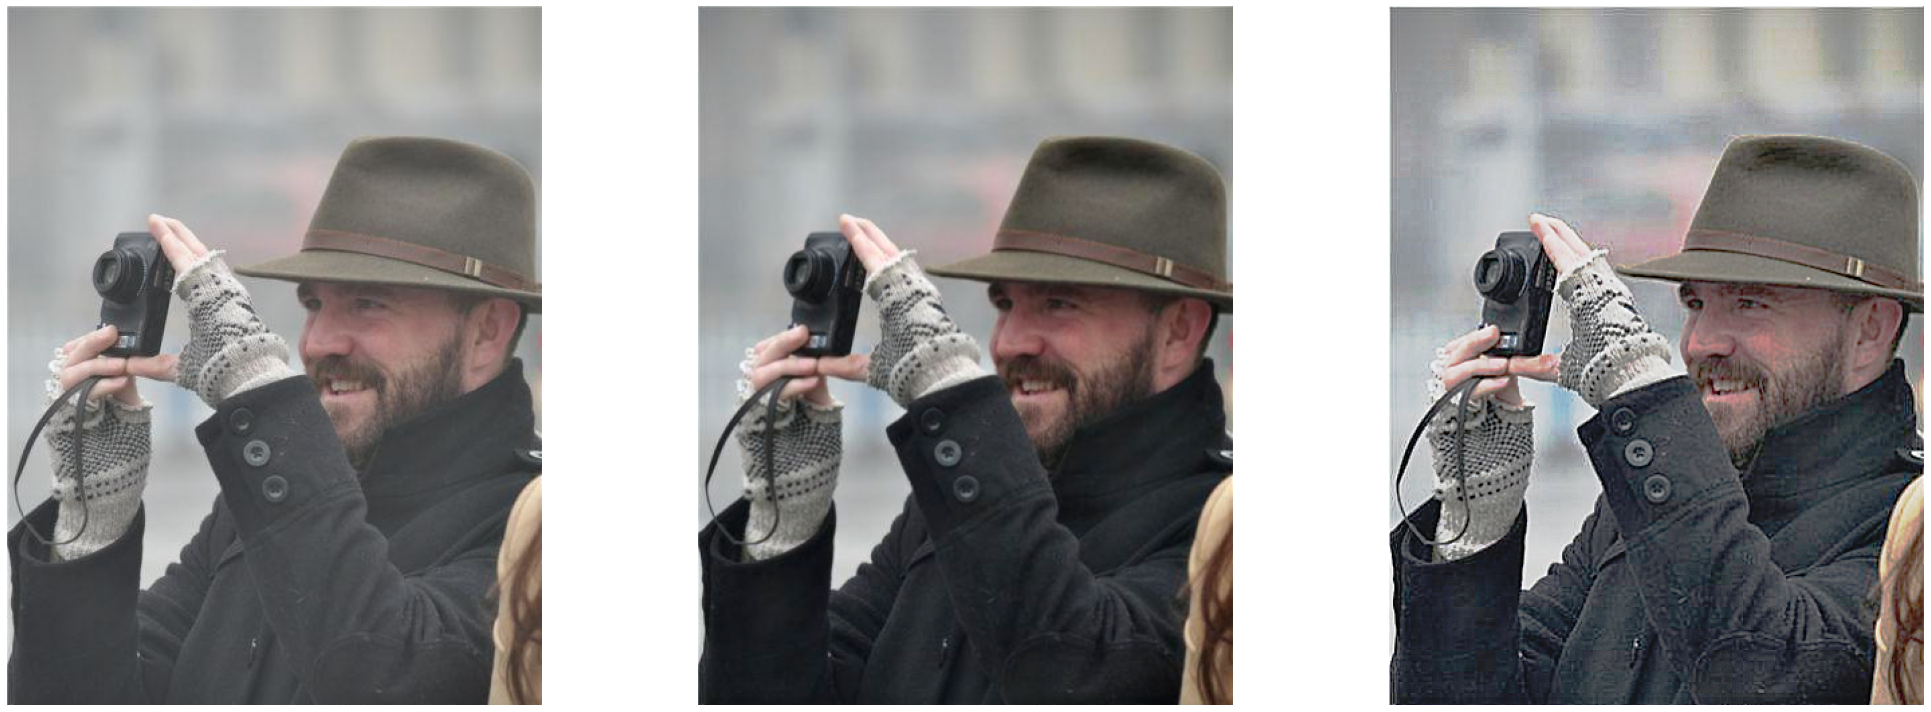

In [ ]:
filepath = "rtts_coco/JPEGImages/HEB_Google_618.png" #@param ['rtts_coco/JPEGImages/HEB_Google_618.png', 'rtts_coco/JPEGImages/WST_Bing_521.png', 'rtts_coco/JPEGImages/BJ_Baidu_748.png', 'rtts_coco/JPEGImages/SY_Google_321.png', 'rtts_coco/JPEGImages/JL_Baidu_057.png', 'rtts_coco/JPEGImages/JL_Google_674.png', 'rtts_coco/JPEGImages/SH_Google_161.png', 'rtts_coco/JPEGImages/QD_Baidu_169.png', 'rtts_coco/JPEGImages/SY_Google_44.png', 'rtts_coco/JPEGImages/MLS_Bing_108.png', 'rtts_coco/JPEGImages/GSGL_Baidu_607.png', 'rtts_coco/JPEGImages/hv42_675.png', 'rtts_coco/JPEGImages/BL_Baidu_213.png', 'rtts_coco/JPEGImages/hv30_145.png', 'rtts_coco/JPEGImages/HEB_Baidu_432.png', 'rtts_coco/JPEGImages/hv42_6.png', 'rtts_coco/JPEGImages/hv17_44.png', 'rtts_coco/JPEGImages/GSGL_Google_396.png', 'rtts_coco/JPEGImages/DJ_Baidu_189.png', 'rtts_coco/JPEGImages/SJZ_Bing_587.png', 'rtts_coco/JPEGImages/KRO_Google_036.png', 'rtts_coco/JPEGImages/GSGL_Bing_122.png', 'rtts_coco/JPEGImages/GSGL_Baidu_148.png', 'rtts_coco/JPEGImages/hv37_1088.png', 'rtts_coco/JPEGImages/BJ_Bing_419.png', 'rtts_coco/JPEGImages/TJ_Baidu_232.png', 'rtts_coco/JPEGImages/HF_Baidu_358.png', 'rtts_coco/JPEGImages/hv19_225.png', 'rtts_coco/JPEGImages/XR_Baidu_164.png', 'rtts_coco/JPEGImages/XG_Baidu_548.png', 'rtts_coco/JPEGImages/HEB_Bing_437.png', 'rtts_coco/JPEGImages/LSJ_Baidu_946.png', 'rtts_coco/JPEGImages/hv9_221.png', 'rtts_coco/JPEGImages/hv50_304.png', 'rtts_coco/JPEGImages/XR_Bing_756.png', 'rtts_coco/JPEGImages/HazeDr_Google_802.png', 'rtts_coco/JPEGImages/hv11_549.png', 'rtts_coco/JPEGImages/TJ_Baidu_583.png', 'rtts_coco/JPEGImages/SJZ_Bing_082.png', 'rtts_coco/JPEGImages/HF_Bing_737.png', 'rtts_coco/JPEGImages/BD_Baidu_134.png', 'rtts_coco/JPEGImages/LZ_Baidu_221.png', 'rtts_coco/JPEGImages/hv4_308.png', 'rtts_coco/JPEGImages/hv30_128.png', 'rtts_coco/JPEGImages/hv37_523.png', 'rtts_coco/JPEGImages/hv39_684.png', 'rtts_coco/JPEGImages/GSGL_Baidu_360.png', 'rtts_coco/JPEGImages/LZ_Bing_111.png', 'rtts_coco/JPEGImages/IRQ_Bing_005.png', 'rtts_coco/JPEGImages/hv6_204.png']

gamma = 1.04 #@param {type:"slider", min:0, max:3, step:0.01}

alpha = 0.3 #@param {type: "slider", min:0, max: 1, step: 0.01}

use_retinex = True #@param {type: "boolean"}

use_alpha_sum = True #@param {type: "boolean"}

use_color_correction = False #@param {type: "boolean"}

use_exposure = True #@param {type: "boolean"}

exposure_weight=0.5 #@param {type: "slider", min:0, max:1, step: 0.01}

use_unsharp_mask=True #@param {type: "boolean"}

hazy_image = cv2.imread(filepath)
dehazed_image, result = merecover(filepath, gamma, alpha, use_retinex, use_alpha_sum, use_color_correction, use_exposure, exposure_weight, use_unsharp_mask)

input_rgb   = cv2.cvtColor(hazy_image, cv2.COLOR_BGR2RGB)
dehazed_rgb = cv2.cvtColor(dehazed_image, cv2.COLOR_BGR2RGB)
result_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

imshow3(input_rgb, dehazed_rgb, result_rgb)
if not before is None:
  imshow3(input_rgb, dehazed_rgb, result_rgb)

before = result_rgb

In [ ]:
# !rm -rf enchanced
# !mkdir enhanced
# !mkdir enhanced/JPEGImages 
# !cp rtts_coco/new_test.json enhanced

In [ ]:
# for filepath in tqdm(glob('rtts_coco/JPEGImages/*.png')):
#   dehazed_image, result = merecover(filepath, gamma, alpha, use_retinex, use_alpha_sum, use_color_correction, use_exposure, exposure_weight, use_unsharp_mask)
#   cv2.imwrite(os.path.join('enhanced/JPEGImages', os.path.basename(filepath)), result)

  0%|          | 0/4322 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)


In [57]:
!mkdir -p dehazed/JPEGImages

In [54]:
!rm -rf rtts_coco
!cp /content/mmdetection/drive/MyDrive/haze/data/RTTS.zip .
!unzip -q RTTS.zip
!mv RTTS rtts_coco 
!cp /content/mmdetection/drive/MyDrive/new_test.json rtts_coco

In [55]:
for filepath in tqdm(glob('rtts_coco/JPEGImages/*.png')):
  dehazed_image = restore_image(filepath) # RGB
  dehazed_image = cv2.cvtColor(dehazed_image, cv2.COLOR_RGB2BGR) # BGR
  cv2.imwrite(os.path.join('dehazed/JPEGImages', os.path.basename(filepath)), dehazed_image)

  0%|          | 0/4322 [00:00<?, ?it/s]

In [56]:
!cp /content/mmdetection/drive/MyDrive/new_test.json dehazed

### Evaluate the detection model

In [58]:
def fix_outputs(fix_outputs):
    new_outputs = []
    for output in outputs:
        new_output = []
        for i in range(80):
            new_output.append(np.array([], dtype=np.float32).reshape(0, 5))
        for i in [0, 1, 2, 3, 5]:
            new_output[i] = output[0][i]
        new_output[2] = np.vstack([new_output[2], output[0][i]])
        new_outputs.append(new_output)
    return new_outputs

In [59]:
!mkdir checkpoints
!wget -c https://download.openmmlab.com/mmdetection/v2.0/scnet/scnet_x101_64x4d_fpn_20e_coco/scnet_x101_64x4d_fpn_20e_coco-fb09dec9.pth \
      -O checkpoints/scnet_x101_64x4d_fpn_20e_coco-fb09dec9.pth

--2021-11-10 19:51:19--  https://download.openmmlab.com/mmdetection/v2.0/scnet/scnet_x101_64x4d_fpn_20e_coco/scnet_x101_64x4d_fpn_20e_coco-fb09dec9.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.88.36.59
Connecting to download.openmmlab.com (download.openmmlab.com)|47.88.36.59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 611860651 (584M) [application/octet-stream]
Saving to: ‘checkpoints/scnet_x101_64x4d_fpn_20e_coco-fb09dec9.pth’

checkpoints/scnet_x 100%[===================>] 583.52M  6.56MB/s    in 73s     

2021-11-10 19:52:32 (8.03 MB/s) - ‘checkpoints/scnet_x101_64x4d_fpn_20e_coco-fb09dec9.pth’ saved [611860651/611860651]



In [60]:
from glob import glob
import os

from mmcv import Config
from mmdet.datasets import build_dataset
from mmdet.datasets import build_dataloader
from mmdet.apis import single_gpu_test
from mmcv.parallel import MMDataParallel
from mmdet.apis import inference_detector, init_detector, show_result_pyplot

config = 'configs/scnet/scnet_x101_64x4d_fpn_20e_coco.py'
checkpoint = 'checkpoints/scnet_x101_64x4d_fpn_20e_coco-fb09dec9.pth'
model = init_detector(config, checkpoint, device='cuda:0')
model = MMDataParallel(model, device_ids=[0])

Use load_from_local loader


In [61]:
def create_dataset(folder):
  cfg = Config.fromfile('./configs/scnet/scnet_x101_64x4d_fpn_20e_coco.py')
  cfg.dataset_type = 'CocoDataset'
  PREFIX = folder
  cfg.data.test.img_prefix = folder
  cfg.data.test.ann_file = os.path.join(PREFIX, 'new_test.json')
  cfg.data.test.type = 'CocoDataset'
  dataset = build_dataset(cfg.data.test)
  data_loader = build_dataloader(dataset, samples_per_gpu=1, workers_per_gpu=2, dist=False, shuffle=False)
  return dataset, data_loader

In [67]:
!ls

checkpoints   docs	   mmdet.egg-info	 README.md	   RTTS.zip
CITATION.cff  docs_zh-CN   model-index.yml	 README_zh-CN.md   setup.cfg
configs       drive	   net_epoch_15.pth	 requirements	   setup.py
dehazed       LICENSE	   out_dehazed		 requirements.txt  tests
demo	      MANIFEST.in  out_enhanced_retinex  resources	   tools
docker	      mmdet	   pytest.ini		 rtts_coco


In [62]:
!cp /content/mmdetection/drive/MyDrive/enhanced_retinex.zip .
!unzip enhanced_retinex.zip 

Archive:  enhanced_retinex.zip
   creating: enhanced_retinex/
   creating: enhanced_retinex/JPEGImages/
  inflating: enhanced_retinex/JPEGImages/TJ_Google_272.png  
  inflating: enhanced_retinex/JPEGImages/hv36_510.png  
  inflating: enhanced_retinex/JPEGImages/hv6_24.png  
  inflating: enhanced_retinex/JPEGImages/SY_Bing_221.png  
  inflating: enhanced_retinex/JPEGImages/hv39_368.png  
  inflating: enhanced_retinex/JPEGImages/hv10_122.png  
  inflating: enhanced_retinex/JPEGImages/GSGL_Google_095.png  
  inflating: enhanced_retinex/JPEGImages/hv1_86.png  
  inflating: enhanced_retinex/JPEGImages/MLS_Bing_667.png  
  inflating: enhanced_retinex/JPEGImages/hv40_87.png  
  inflating: enhanced_retinex/JPEGImages/NY_Google_283.png  
  inflating: enhanced_retinex/JPEGImages/HF_Baidu_368.png  
  inflating: enhanced_retinex/JPEGImages/HEB_Google_030.png  
  inflating: enhanced_retinex/JPEGImages/BD_Baidu_428.png  
  inflating: enhanced_retinex/JPEGImages/hv42_620.png  
  inflating: enhanced_r

In [63]:
method = 'enhanced_retinex'
!mkdir out_{method}
dataset, data_loader = create_dataset(f'./{method}')
outputs = single_gpu_test(model, data_loader, False, '', 0.3)
dataset.cat_ids.append(91)
metric = dataset.evaluate(fix_outputs(outputs), metric='bbox')

mkdir: cannot create directory ‘out_enhanced_retinex’: File exists
loading annotations into memory...
Done (t=0.47s)
creating index...
index created!
[                                                  ] 0/4320, elapsed: 0s, ETA:

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[>>>>>>>>>>>>>>>>>>>>>>>>>>] 4320/4320, 1.9 task/s, elapsed: 2324s, ETA:     0s
Evaluating bbox...
Loading and preparing results...
DONE (t=1.14s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=72.28s).
Accumulating evaluation results...
DONE (t=8.78s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.340
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.537
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.363
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.121
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.323
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.465
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.429
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.429
 Average Recall     (AR) @[ IoU=0.50:0.95 |

In [63]:
method = 'dehazed'
!mkdir out_{method}
dataset, data_loader = create_dataset(f'./{method}')
outputs = single_gpu_test(model, data_loader, False, '', 0.3)
dataset.cat_ids.append(91)
metric = dataset.evaluate(fix_outputs(outputs), metric='bbox')

loading annotations into memory...
Done (t=0.35s)
creating index...
index created!
[                                                  ] 0/4320, elapsed: 0s, ETA:

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[>>>>>>>>>>>>>>>>>>>>>>>>>>] 4320/4320, 2.0 task/s, elapsed: 2159s, ETA:     0s
Evaluating bbox...
Loading and preparing results...
DONE (t=0.87s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=55.29s).
Accumulating evaluation results...
DONE (t=6.96s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.362
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.567
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.390
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.156
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.345
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.477
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.447
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.447
 Average Recall     (AR) @[ IoU=0.50:0.95 |